# INF8775 – Analyse et conception d’algorithmes
# TP1 – Automne 2025

Perron Touchette, Thomas, 2201589

BENOUHOUD, Mehdi, 2188585

Note finale :

 **Date limite de remise :** 30 septembre (B2), 7 octobre (B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat. Cela s'applique aussi au niveau de l'IA générative pour le code. Par contre, vous devez être capable d'accomplir les analyses par vous-même. Vous ne pouvez pas utiliser l'IA pour ces sections.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [1]:
!pip install matplotlib numpy

In [2]:
# Problem data
example_buildings = [(2, 13, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

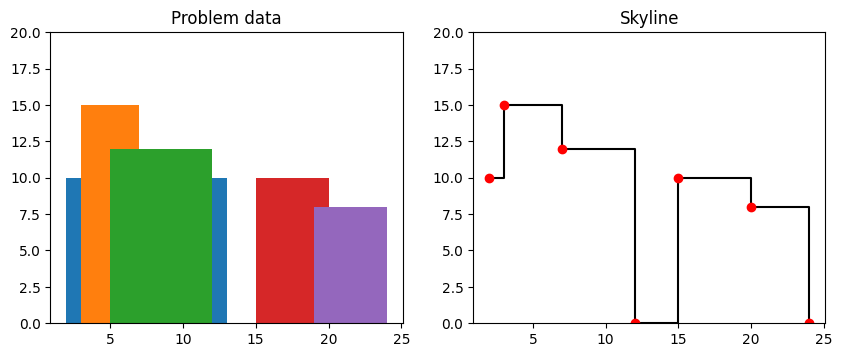

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse.


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [4]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

In [5]:
dataset = get_dataset(2188585, [5, 10, 25, 50, 75, 100, 150, 250, 300, 500, 750, 1_000, 1_500, 2_500, 5_000])

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [7]:
import matplotlib.pyplot as plt
import time
import statistics as stats

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    """ Mesure le temps moyen d'execution d'une procédure sur une liste d'exemplaires """
    total_time = 0
    for sample in samples:
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b = stats.linear_regression(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label='Regression linéaire')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b = stats.linear_regression(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label='Regression linéaire')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()


def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()


## Algorithme naïf (brute force) (6 points)

### Implémentation (1.5 points)

TODO: Implantez un algorithme naïf pour le problème de la ligne d'horizon.

TODO: Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

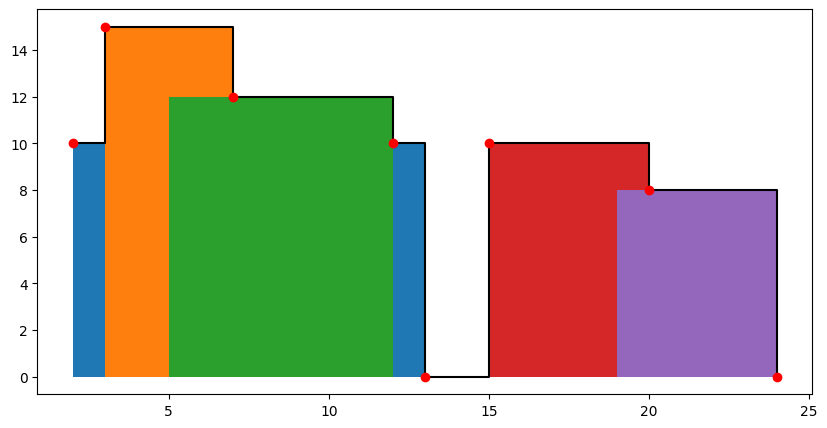

In [8]:
def skyline_bruteforce(buildings: list[tuple[int, int, int]]) -> list[tuple[int, int]]:
    """
    Computes the skyline using a brute-force approach. Our implementation is voluntarily very inefficient to show the benefits of divide and conquer.

    Args:
        buildings (list of tuples): A list where each tuple represents a building in the format (left, right, height).
    Returns:
        A list of tuples representing the skyline in the format (x, height).
    """
    if not buildings:
        return []
    
    min_x = min(building[0] for building in buildings)
    max_x = max(building[1] for building in buildings)

    skyline = []
    previous_height = 0

    for x in range(min_x, max_x + 1):

        current_height = 0
        for building in buildings:
            left, right, height = building
            if left <= x < right:
                current_height = max(current_height, height)

        if current_height != previous_height:
            skyline.append((x, current_height))
            previous_height = current_height
    return skyline


verification_plot(example_buildings, skyline_bruteforce(example_buildings))

### Analyse asymptotique (1 points)

TODO: Quelle est la complexité asymptotique théorique de cet algorithme?

La complexité asymptotique théorique de cet algorithme est O(n^2). 

### Mesures (0.5 points)

In [9]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [10]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
5            3.0517578125e-05
10           6.546974182128907e-05
25           0.00036292076110839845
50           0.0011992931365966796
75           0.0029631137847900392
100          0.0051785469055175785
150          0.012508153915405273
250          0.03287348747253418
300          0.04646172523498535
500          0.1320183753967285
750          0.28267598152160645
1000         0.5161883354187011
1500         1.1499503135681153
2500         3.392037200927734
5000         13.49301118850708


### Analyse hybride

#### Test de puissance (1 point)

Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

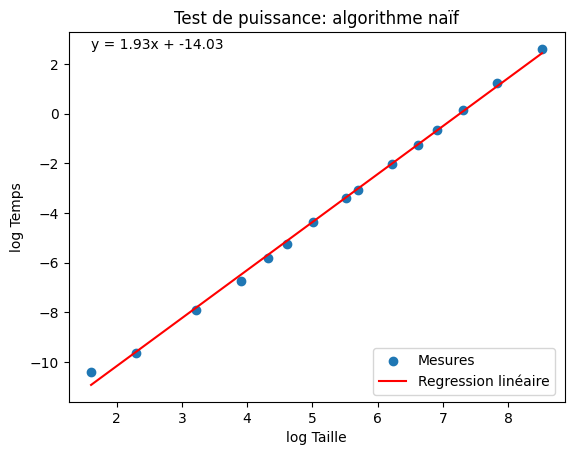

In [11]:
import math

def values_test_puissance(measures):
    return {
        math.log(size): math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")


#### Analyse du graphique du test de puissance pour l'algorithme naïf

On constate que dans un graphique du test de puissance à échelle log-log, les points suivent très étroitement la droite d'équation log_a(y) = m * log_a(x) + b => y = a^b + x^m, où m = 1.93 ≈ 2; b = -14.03

En ce sens, on peut donc en conclure que l'algorithme que nous avons implémenté est de complexité asymptotique de O(n^1.93). Étant donné qu'il peut y avoir de légères variations et du « bruit », on peut arrondir légèrement à la hausse. C'est donc dire que l'algorithme est de complexité algorithmique asymptotique d'environ O(n^2).

#### Test du rapport (1 point)

Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

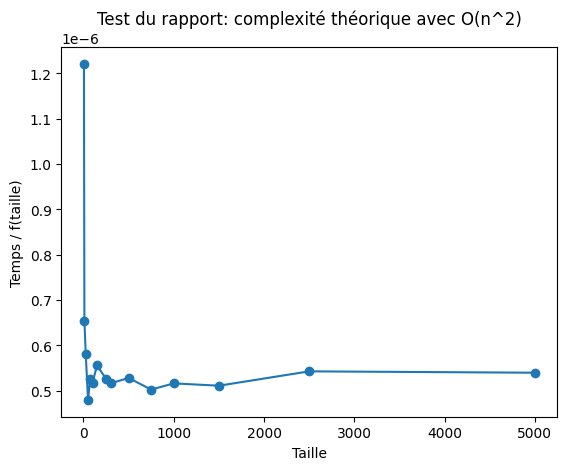

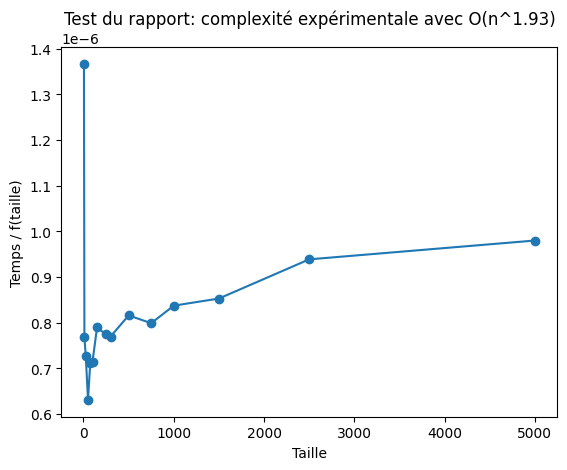

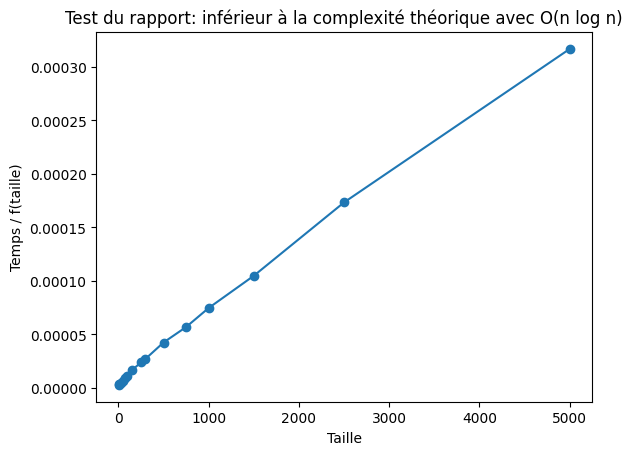

In [12]:
import math
def values_test_rapport(measures, f):
    return {
        size : measure / f(size)
        for size, measure in measures.items()
    }

def f(x):
    return x**2

def g(x):
    return x**1.93

def h(x):
    return x * math.log(x)


display_test_rapport(values_test_rapport(measures_bruteforce, f), "Test du rapport: complexité théorique avec O(n^2)")
display_test_rapport(values_test_rapport(measures_bruteforce, g), "Test du rapport: complexité expérimentale avec O(n^1.93)")
display_test_rapport(values_test_rapport(measures_bruteforce, h), "Test du rapport: inférieur à la complexité théorique avec O(n log n)")

#### Analyse des graphiques du test du rapport

Nous avons effectué le test du rapport avec les trois fonctions suivantes: O(n^2), O(n^1.95) et O(nlog(n)).

##### Pourquoi ces fonctions?

O(n^2) car il s'agit de la complexité asymptotique théorique de notre algorithme.

O(n^1.93) car il s'agit de la complexité asymptotique expérimentale de notre algorithme. En théorie, le test du rapport devrait confirmer que cette estimation est la bonne et pourrait sous-ligner une légère surestimation de la complexité O(n^2)

O(nlog(n)) car il s'agit de la complexité asymptotique théorique la plus complexe qui l'est tout de même moins que O(n^2). En rappel: O(n^2) > O(nlog(n))

##### Que conclure des graphiques du test du rapport

Pour O(n^2), les points semblent converger vers une valeur vers une constante b > 0. Conclusion: estimation correcte

Idem pour O(n^1.93)

En revanche, pas de convergence pour O(nlog(n)), ce qui nous confirme qu'il s'agirait d'une sous-estimation.

### Test des constantes (1 point)

Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

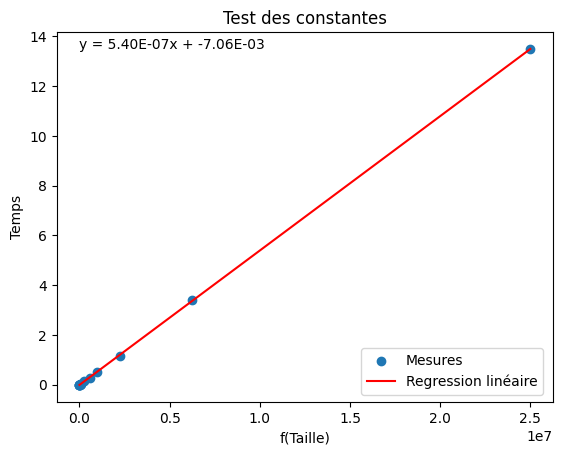

In [13]:
def values_test_constantes(measures, f):
    return {
        f(size) : measure
        for size, measure in measures.items()
    }

def f(x):
    return x**2

display_test_constantes(values_test_constantes(measures_bruteforce, f))

#### Analyse du test des constantes

On observe ici deux constantes mises en valeur par la droite de régression d'équation y = mx + b. 

Tout d'abord la valeur de y, qui correspond à la constante multiplicative cachée c dans y = c * f(x) + b. y = 5.40 * 10^-7

Ensuite la valeur de b, l'ordonnée à l'origine qui correspond au offset. b ≈ - 7.06 * 10^-3

Ainsi, cela veut donc dire que si l'on veut obtenir le temps moyen que prendra cet algorithme pour une taille de 3 000, on ferait 

T(3 000) = 5.40 * 10^-7 * (3 000) ^ 2 - 7.06 * 10^-3 ≈ 4.85 secondes


## Algorithme diviser pour régner (6 points)


### Implémentation (1.5 points)

TODO: Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Il est conseillé de prévoir un paramètre pour le seuil de récursivité (e.g. `threshold`), en dessous duquel, vous utiliserez l'algorithme naïf écrit précédemment. Dans ce cas, le seuil devrait être 1.

In [14]:
def merge_skylines(left: list[tuple[int, int]], right: list[tuple[int, int]]) -> list[tuple[int, int]]:
    """
    Merges two skylines into one.
    Merge algorithm inspired by https://heycoach.in/blog/the-skyline-problem-solution-in-python/

    Args:
        left (list of tuples): The left skyline represented as a list of (x, height) tuples.
        right (list of tuples): The right skyline represented as a list of (x, height) tuples.
    Returns:
        A list of tuples representing the merged skyline in the format (x, height).
    """
    left_skyline_height, right_skyline_height = 0, 0
    left_i, right_i = 0, 0
    merged = []
    
    while left_i < len(left) and right_i < len(right):
        if left[left_i][0] < right[right_i][0]:
            x, left_skyline_height = left[left_i]
            left_i += 1
        elif left[left_i][0] > right[right_i][0]:
            x, right_skyline_height = right[right_i]
            right_i += 1
        else:
            x = left[left_i][0]
            left_skyline_height = left[left_i][1]
            right_skyline_height = right[right_i][1]
            left_i += 1
            right_i += 1
        
        max_h = max(left_skyline_height, right_skyline_height)
        if not merged or merged[-1][1] != max_h:
            merged.append((x, max_h))
    
    while left_i < len(left):
        if not merged or merged[-1][1] != left[left_i][1]:
            merged.append(left[left_i])
        left_i += 1
    
    while right_i < len(right):
        if not merged or merged[-1][1] != right[right_i][1]:
            merged.append(right[right_i])
        right_i += 1

    return merged

def skyline_divide_and_conquer(buildings: list[tuple[int, int, int]], threshold: int) -> list[tuple[int, int]]:
    """
    Computes the skyline using a divide-and-conquer approach with a specified recursion threshold.
    Args:
        buildings (list of tuples): A list where each tuple represents a building in the format (left, right, height).
        threshold (int): The recursion threshold to switch to brute-force method.
    
    Returns:
        A list of tuples representing the skyline in the format (x, height).
    """
    n = len(buildings)

    if n == 0:
        return []
    #if n == 1:
    #    left, right, height = buildings[0]
    #    return [(left, height), (right, 0)]
    if n <= threshold:
        return skyline_bruteforce(buildings)

    mid = n // 2
    left_skyline = skyline_divide_and_conquer(buildings[:mid], threshold)
    right_skyline = skyline_divide_and_conquer(buildings[mid:], threshold)

    return merge_skylines(left_skyline, right_skyline)

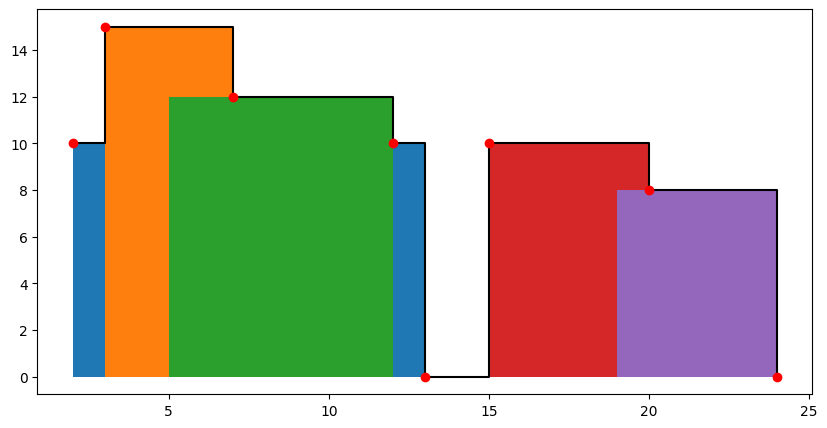

In [15]:
def skyline_divide_and_conquer_naive_threshold(buildings: list[tuple[int, int, int]]) -> list[tuple[int, int]]:
    return skyline_divide_and_conquer(buildings, 1)

verification_plot(example_buildings, skyline_divide_and_conquer_naive_threshold(example_buildings))

### Analyse asymptotique (1 points)

Quelle est la complexité asymptotique théorique de cet algorithme? **O(nlog(n))**

### Mesures (0.5 points)

In [16]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer_naive_threshold, dataset)

In [17]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
5            3.457069396972656e-05
10           5.817413330078125e-05
25           0.00017070770263671875
50           0.000348663330078125
75           0.0007157325744628906
100          0.000784921646118164
150          0.001488065719604492
250          0.002982425689697266
300          0.003414440155029297
500          0.005877351760864258
750          0.008632946014404296
1000         0.011203765869140625
1500         0.01691722869873047
2500         0.02885298728942871
5000         0.059411048889160156


### Analyse hybride

#### Test de puissance (1 point)

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

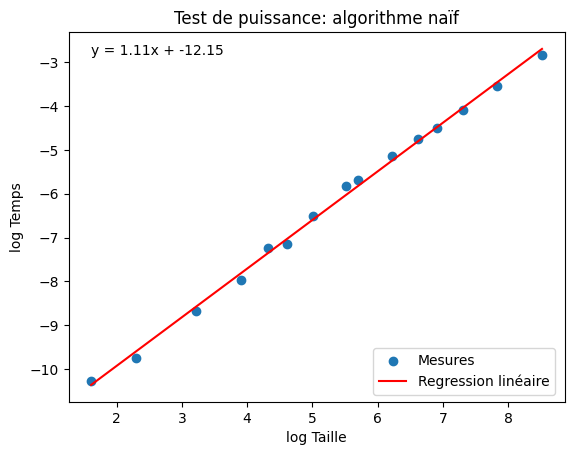

In [18]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: algorithme naïf")

#### Analyse du graphique du test de puissance pour l'algorithme naïf

On constate que dans un graphique du test de puissance à échelle log-log, les points suivent très étroitement la droite d'équation log_a(y) = m * log_a(x) + b => y = a^b + x^m, où m = 1.11 ≈ 2; b = -12.15

En ce sens, on peut donc en conclure que l'algorithme que nous avons implémenté est de complexité asymptotique de O(n^1.11). C'est donc dire que l'algorithme est de complexité algorithmique asymptotique d'environ O(n). Comme il y a une régression linéaire, il y a un taux de croissance polynomiale de degré 1. Cependant, le test de puissance ne mesurant que la puissance, il est normal que le test de puissance fasse restortir une puissance de 1. Le résultat de ce test n'est pas incompatible avec une complexité réelle de O(nlog(n)) comme démontrée plus tard.

#### Test du rapport (1 point)

Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

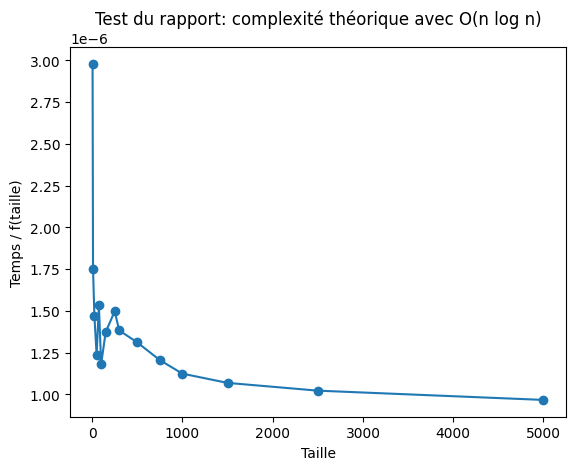

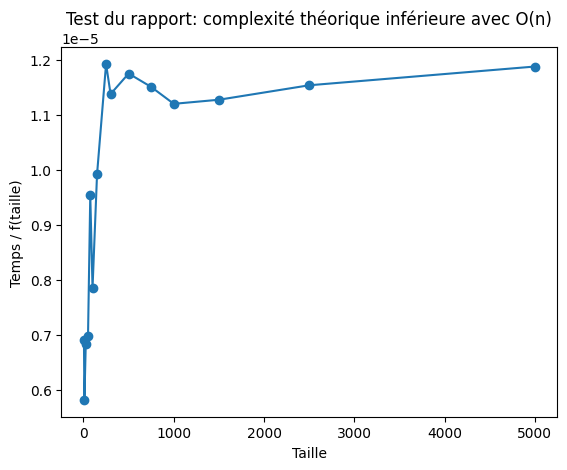

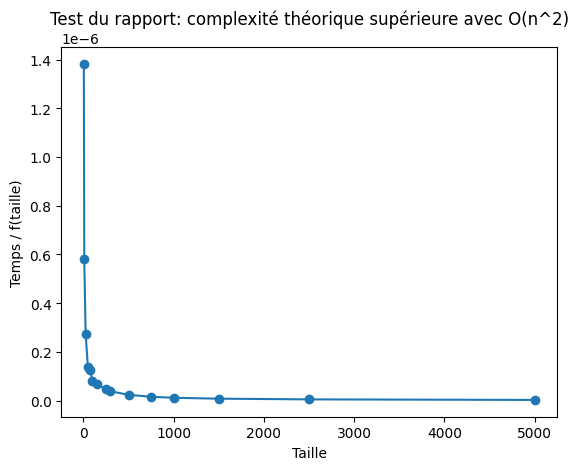

In [19]:
def f(x):
    return x * math.log2(x)

def g(x):
    return x

def h(x):
    return x**2

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f), "Test du rapport: complexité théorique avec O(n log n)")
display_test_rapport(values_test_rapport(measures_divide_naive_threshold, g), "Test du rapport: complexité théorique inférieure avec O(n)")
display_test_rapport(values_test_rapport(measures_divide_naive_threshold, h), "Test du rapport: complexité théorique supérieure avec O(n^2)")

#### Analyse des graphiques du test du rapport

Nous avons effectué le test du rapport avec les trois fonctions suivantes: O(n*log(n)), O(n) et O(n^2)

##### Pourquoi ces fonctions?

O(n*log(n)), car c'est la complexité asymptotique théorique de l'algorithme

O(n) car c'est la complexité asymptotique théorique la plus grande qui est inférieure à celle de l'algorithme

O(n^2) car c'est la plus petite complexité qui est supérieure à celle de l'algorithme

##### Que conclure des graphiques du test du rapport

Le graphique de O(n * log(n)) converge vers b > 0, l'estimation est bonne

O(n) ne semble pas converger, c'est donc une sous-estimation

O(n^2) converge vers 0, c'est donc un sur-estimation

Nous pouvons donc conclure que l'estimation O(n*log(n)) est la bonne

### Test des constantes (1 point)

Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

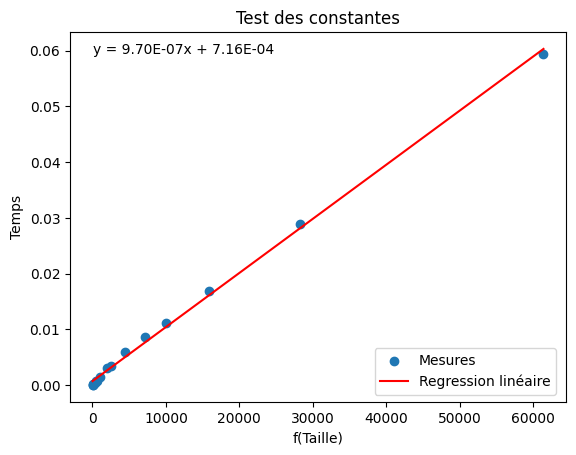

In [20]:
def f(x):
    return x * math.log2(x)

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

#### Analyse du test des constantes

On observe ici deux constantes mises en valeur par la droite de régression d'équation y = mx + b. 

Tout d'abord la valeur de y, qui correspond à la constante multiplicative cachée c dans y = c * f(x) + b. y = 9.70 * 10^-7

Ensuite la valeur de b, l'ordonnée à l'origine qui correspond au offset. b ≈ 7.16 * 10^-4

Ainsi, cela veut donc dire que si l'on veut obtenir le temps moyen que prendra cet algorithme pour une taille de 10 000, on ferait 

T(10 000) = 9.70 * 10^-7 * 10 000 * log_2(10 000) + 7.16 * 10^-4 = 0.129 6 secondes

## Algorithme diviser pour régner (seuil choisi) (6 points)

### Sélection du seuil (1.5 points)

Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [37]:

BIG_DATASET = get_dataset(2188585, [50_000])
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer(sample, i),
        BIG_DATASET[50_000])
        for i in range(1, 15)
}

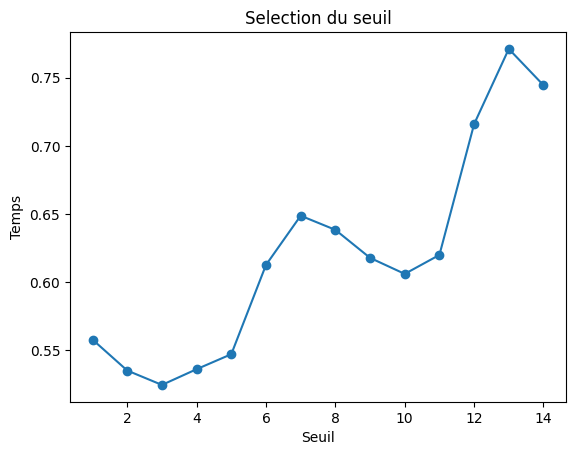

Taille       Temps moyen (s)
1            0.5578340053558349
2            0.5351510524749756
3            0.5246058464050293
4            0.5361518859863281
5            0.5471528530120849
6            0.6126549720764161
7            0.6487480640411377
8            0.6383759021759033
9            0.6178239345550537
10           0.6060583591461182
11           0.6199758052825928
12           0.715962028503418
13           0.7711149692535401
14           0.7444747924804688
Le seuil optimal est 3


In [38]:

display_mesures_seuil(measures_threshold)
display_measures_table(measures_threshold)

min_threshold = min(measures_threshold.items(), key=lambda x: x[1])[0]
print(f"Le seuil optimal est {min_threshold}")

Le seuil de récursivité le plus judicieux semble être 3, car il s'agit du juste milieu entre l'utilisation de l'algorithme naÏf et de l'algorithme diviser pour régner. L'algorithme D&R peut parfois être moins efficace dépendament du seuil car il consomme des ressources par récursivité et pour fusionner les *skylines* par exemple.

Utilisez votre fonction générique pour implanter un algorithme avec le seuil choisi.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

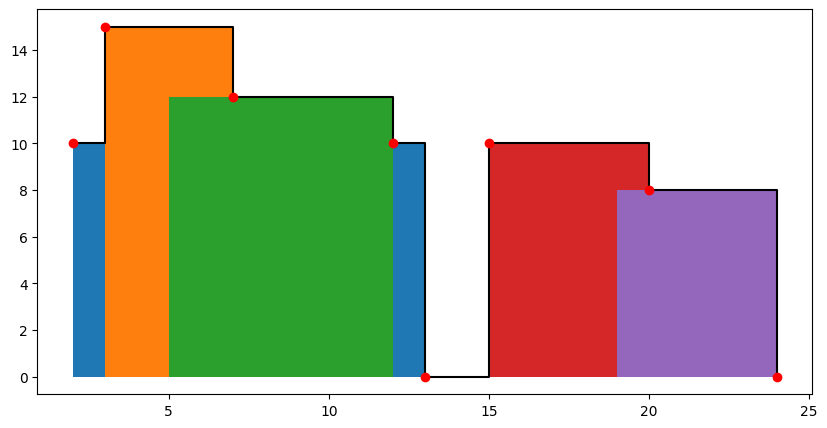

In [39]:
def skyline_divide_and_conquer_best_threshold(buildings):
    # TODO diviser pour régner avec un seuil de récursivité de n
    return skyline_divide_and_conquer(buildings, 3)

verification_plot(example_buildings, skyline_divide_and_conquer_naive_threshold(example_buildings))

### Analyse asymptotique (1 points)

L'algorithme *skyline_divide_and_conquer_best_threshold* devrait avoir la même complexité asymptotique que l'algorithme *skyline_divide_and_conquer_naive_threshold*, car la seule différence est que la version *best* effectura moins d'appel récursif que le *naive*. Cependant, le nombre d'appel devrait tout de même suivre le logarithme en base 2 de *n* suivi d'une fusion de toutes les divisions qui sera linéaire à *n*. Alors, nous obtenons une complexité: **O(nlog(n))**

### Mesures (0.5 points)

In [40]:
measures_divide_best_threshold = measure_procedure(skyline_divide_and_conquer_best_threshold, dataset)

In [41]:
display_measures_table(measures_divide_best_threshold)


Taille       Temps moyen (s)
5            2.7179718017578125e-05
10           4.897117614746094e-05
25           0.00015134811401367186
50           0.00029964447021484374
75           0.0006121158599853516
100          0.0007608413696289062
150          0.0011148452758789062
250          0.001789236068725586
300          0.002214860916137695
500          0.004098129272460937
750          0.006181526184082031
1000         0.00810999870300293
1500         0.012456130981445313
2500         0.022119569778442382
5000         0.045036840438842776


### Analyse hybride

#### Test de puissance (1 point)

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

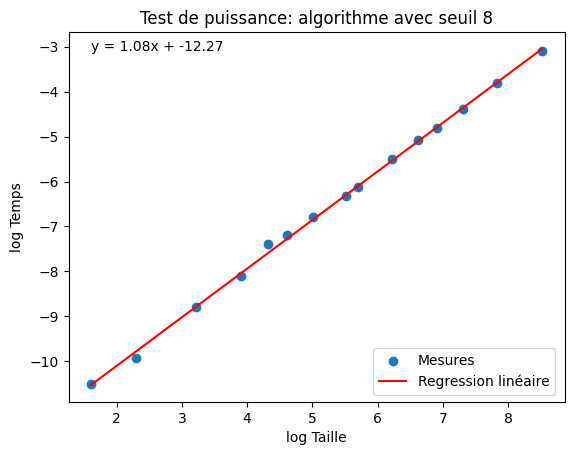

In [42]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme avec seuil 8")

#### Analyse du graphique du test de puissance pour l'algorithme avec seuil

On constate que dans un graphique du test de puissance à échelle log-log, les points suivent très étroitement la droite d'équation log_a(y) = m * log_a(x) + b => y = a^b + x^m, où m = 1.08 ≈ 1; b = -12.27

En ce sens, on peut donc en conclure que l'algorithme que nous avons implémenté est de complexité asymptotique de O(n^1.08). C'est donc dire que l'algorithme est de complexité algorithmique asymptotique d'environ O(n). Comme il y a une régression linéaire, il y a un taux de croissance polynomiale de degré 1. Cependant, le test de puissance ne mesurant que la puissance, il est normal que le test de puissance fasse restortir une puissance de 1. Le résultat de ce test n'est pas incompatible avec une complexité réelle de O(nlog(n)) comme démontrée plus tard.

#### Test du rapport (1 point)

Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

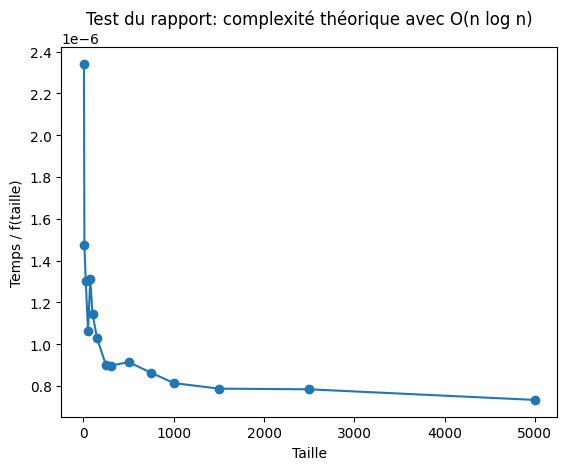

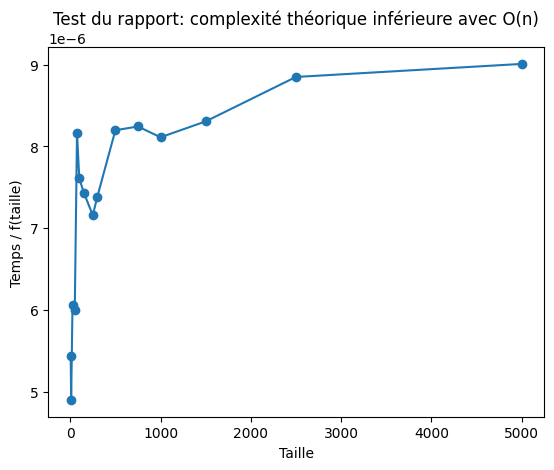

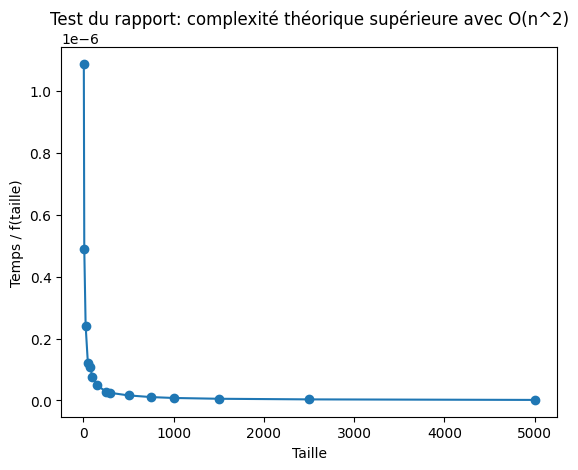

In [43]:
def f(x):
    return x * math.log2(x)

def g(x):
    return x

def h(x):
    return x**2

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f), "Test du rapport: complexité théorique avec O(n log n)")
display_test_rapport(values_test_rapport(measures_divide_best_threshold, g), "Test du rapport: complexité théorique inférieure avec O(n)")
display_test_rapport(values_test_rapport(measures_divide_best_threshold, h), "Test du rapport: complexité théorique supérieure avec O(n^2)")

#### Analyse des graphiques du test du rapport

Nous avons effectué le test du rapport avec les trois fonctions suivantes: O(n*log(n)), O(n) et O(n^2)

##### Pourquoi ces fonctions?

O(n*log(n)), car c'est la complexité asymptotique théorique de l'algorithme

O(n) car c'est la complexité asymptotique théorique la plus grande qui est inférieure à celle de l'algorithme

O(n^2) car c'est la plus petite complexité qui est supérieure à celle de l'algorithme

##### Que conclure des graphiques du test du rapport

Le graphique de O(n * log(n)) converge vers b > 0, l'estimation est bonne

O(n) ne semble pas converger, c'est donc une sous-estimation.

O(n^2) converge vers 0, c'est donc un sur-estimation

Nous pouvons donc conclure que l'estimation O(n*log(n)) est la bonne

### Test des constantes (1 point)

Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

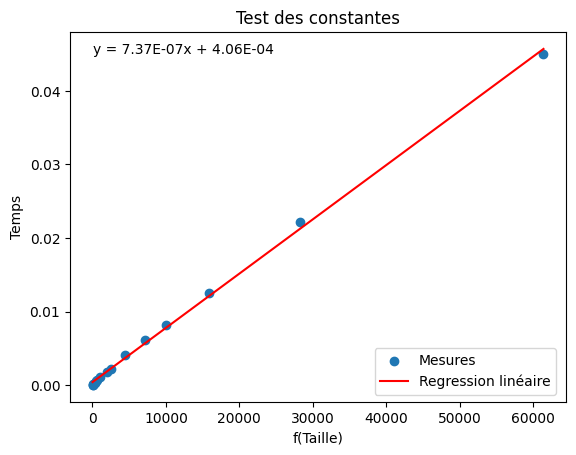

In [44]:
def f(x):
    return x * math.log2(x)

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


#### Analyse du test des constantes

On observe ici deux constantes mises en valeur par la droite de régression d'équation y = mx + b. 

Tout d'abord la valeur de y, qui correspond à la constante multiplicative cachée c dans y = c * f(x) + b. y = 7.37 * 10^-7

Ensuite la valeur de b, l'ordonnée à l'origine qui correspond au offset. b ≈ 4.06 * 10^-4

Ainsi, cela veut donc dire que si l'on veut obtenir le temps moyen que prendra cet algorithme pour une taille de 10 000, on ferait 

T(10 000) = 7.37 * 10^-7 * 10 000 * log_2(10 000) + 4.06 * 10^-4 = 0.007 37 secondes

# Conclusion (2 points)


TODO: Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

Pour conclure, nous pouvons remarquer que le seuil de récursivité peut avoir un grand impact sur l'algorithme diviser pour régner autant en l'améliorer que en réduisant son efficacité. Le seuil de récursivité représente la condition de fin pour les appels récursifs pour l'algorithme diviser pour régner. Le seuil de récursivité représente la taille minimale de problème où l'algorithme naïf est le plus performant.

TODO: En vous basant sur vos résultats, résumez vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes en démontrant leurs points forts et point faibles. 


### L'algorithme naïf

L'algorithme naïf devrait être utilisé pour résoudre un problème lorsqu'on y est confronté pour la première fois. De ce fait, le problème peut être plus facilement cerné avec une résolution simple. De plus, cette solution dîtes naïve peut être conservé si les tailles de données reste assez petite. En effet, généralement la solution naïve est aussi performante qu'une solution complexe et optimisé lorsque la taille de données est petite. On peut conclure que l'algorithme naïf est simple et résout le problème donné, mais est rapidement trop lent pour des échantillons trop grand.

### L'algorithme diviser pour régner avec seuil naïf

L'algorithme diviser pour régner avec seuil naïf devrait être utilisé après l'implémentation d'un algorithme naïf. De plus, il devrait être utilisé si l'on commence à utiliser des tailles de données qui sont assez grande ou si l'on a besoin de meilleur performance de manière générale. On peut conclure que l'algorithme diviser pour régner est certe plus performante, mais nettement plus complexe à implémenter voir dans certains cas impossible.

### L'algorithme diviser pour régner avec seuil optimisé

L'algorithme diviser pour régner avec seuil optimisé devrait être utilisé à la suite de l'implémentation de diviser pour régner avec seuil naïf. Cette algorithme est utile pour maximiser la performance de l'algorithme diviser pour régner naïf, cependant il peut être plus compliqué de déterminer le seuil _parfait_ en fonction du problème et du nombre de dépendance des données, par exemple s'il y a des données x1, x2, etc... 


 ## Autres critères


Présentation générale / -
1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.